In [70]:
#---------------------- 1. 基础数据处理和分析 ----------------------
import numpy as np
import pandas as pd
from collections import Counter
from scipy import stats

#---------------------- 2. 数据可视化 ----------------------
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
plt.rcParams['font.family'] = 'Times New Roman'  

#---------------------- 3. 机器学习工具 ----------------------
# 3.1 基础工具
from sklearn.model_selection import train_test_split, KFold, cross_val_score as cvs
from sklearn.preprocessing import label_binarize, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline as pp

# 3.2 特征工程
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE  # 处理数据不平衡问题

# 3.3 模型算法
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb

# 3.4 模型评估
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score,
)

#---------------------- 4. 超参数优化 ----------------------
import optuna
import pyttsx3
from optuna.visualization import (
    plot_optimization_history,
    plot_parallel_coordinate,
    plot_param_importances
)

# Preprocess

## load data

In [50]:
dataset = pd.read_excel(r"Dataset/merged_dataset.xlsx",skiprows=1)  #读取数据
columns = dataset.columns
print(list(columns))
for col in temp_col[6:]:
    dataset[col] = pd.to_numeric(dataset[col], errors='coerce')  #数字化
data_merged_dataset = dataset.loc[:,temp_col]
data_merged_dataset
# data_merged_dataset.to_excel("../Dataset/Supplementary/EM1.xlsx", sheet_name = "merged_dataset")


['Reference', 'Genetic type', 'Sample', 'Sample no.', 'Detail', 'inherit', 'La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Y', 'Ti', 'Nb', 'Hf', 'Ta', 'Pb', 'Th', 'U', 'Sr']


,Genetic type,Sample,Sample no.,Detail,inherit,La,Ce,Pr,Nd,Sm,...,Lu,Y,Ti,Nb,Hf,Ta,Pb,Th,U,Sr
0,S-type,ZNX–0,ZNX–0–1,Grainte,0,3.1,56.5,1.00,3.50,4.30,...,84.1,1228.0,3.7,13.30,10654.0,3.10,34.0,538.0,511.0,0.9
1,S-type,ZNX–0,ZNX–0–2,Grainte,0,0,53.5,0.05,0.80,2.30,...,198.0,2519.0,0.6,43.00,16762.0,12.30,63.1,2094.0,2684.0,0.4
2,S-type,ZNX–0,ZNX–0–3,Grainte,0,89,166.3,11.70,34.80,12.80,...,254.5,3672.0,7.4,74.90,12473.0,18.30,128.0,2512.0,3408.0,6.5
3,S-type,ZNX–0,ZNX–0–4,Grainte,0,0.3,37.6,0.10,1.20,3.10,...,471.8,4441.0,4.5,148.40,17631.0,36.10,172.9,2535.0,15357.0,0.8
4,S-type,ZNX–0,ZNX–0–5,Grainte,0,0,36.5,0.05,0.70,2.70,...,69.2,1026.0,4.3,3.40,11197.0,1.10,3.7,201.0,194.0,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4053,A2-type,08HL07,08HL07-21,Feldspar Granite,0,2.17,20.4,0.73,4.50,4.11,...,38.8,713.0,9.4,2.14,10110.0,0.95,NaN,94.5,93.9,NaN
4054,A2-type,08HL07,08HL07-22,Feldspar Granite,0,0.01,20.5,0.04,1.35,2.30,...,27.9,499.0,13.7,1.67,9137.0,0.71,NaN,59.2,46.2,NaN
4055,A2-type,08HL07,08HL07-23,Feldspar Granite,0,bd,16.9,0.04,0.81,1.82,...,23.5,409.0,7.9,2.10,9692.0,0.85,NaN,68.6,60.6,NaN
4056,A2-type,08HL07,08HL07-24,Feldspar Granite,0,0.02,14.0,0.14,1.87,3.28,...,27.7,542.0,19.6,1.60,8850.0,0.62,NaN,45.2,29.6,NaN


## del inherited and captured zircon

In [51]:
cols = [
    "Reference",'Genetic type',"Sample", "Sample no.","inherit", "Detail", 
    "Ce","Pr", 'Nd', 'Sm', 'Eu', 'Gd', "Tb", "Dy", "Ho",'Er', 'Tm', 'Yb','Lu', "Th", "U","Nb","Y"
    ]  #所选元素
data = dataset[cols]
data = data[data["inherit"] == 0]
print(Counter(data["Genetic type"]))
cols_check = data.columns[7:]
for col in cols_check:
    data[col] = data[col].apply(lambda x: np.nan if x==0 else x)
data = data.dropna(subset = cols_check)
data

Counter({'A2-type': 1084, 'I-type': 1062, 'S-type': 881, 'A1-type': 627})


,Reference,Genetic type,Sample,Sample no.,inherit,Detail,Ce,Pr,Nd,Sm,...,Dy,Ho,Er,Tm,Yb,Lu,Th,U,Nb,Y
0,Cao et al. 2017,S-type,ZNX–0,ZNX–0–1,0,Grainte,56.5,1.00,3.50,4.30,...,96.1,37.9,182.7,41.2,451.0,84.1,538.0,511.0,13.30,1228.0
1,Cao et al. 2017,S-type,ZNX–0,ZNX–0–2,0,Grainte,53.5,0.05,0.80,2.30,...,172.3,73.8,385.6,88.7,1024.3,198.0,2094.0,2684.0,43.00,2519.0
2,Cao et al. 2017,S-type,ZNX–0,ZNX–0–3,0,Grainte,166.3,11.70,34.80,12.80,...,275.7,110.2,534.0,122.7,1357.7,254.5,2512.0,3408.0,74.90,3672.0
3,Cao et al. 2017,S-type,ZNX–0,ZNX–0–4,0,Grainte,37.6,0.10,1.20,3.10,...,259.2,115.8,654.3,173.5,2226.5,471.8,2535.0,15357.0,148.40,4441.0
4,Cao et al. 2017,S-type,ZNX–0,ZNX–0–5,0,Grainte,36.5,0.05,0.70,2.70,...,78.8,31.0,153.3,33.6,367.2,69.2,201.0,194.0,3.40,1026.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4053,Peng et al. 2012,A2-type,08HL07,08HL07-21,0,Feldspar Granite,20.4,0.73,4.50,4.11,...,65.2,24.3,106.8,23.1,221.0,38.8,94.5,93.9,2.14,713.0
4054,Peng et al. 2012,A2-type,08HL07,08HL07-22,0,Feldspar Granite,20.5,0.04,1.35,2.30,...,46.2,16.8,75.2,16.5,161.0,27.9,59.2,46.2,1.67,499.0
4055,Peng et al. 2012,A2-type,08HL07,08HL07-23,0,Feldspar Granite,16.9,0.04,0.81,1.82,...,35.4,13.4,60.6,13.5,128.0,23.5,68.6,60.6,2.10,409.0
4056,Peng et al. 2012,A2-type,08HL07,08HL07-24,0,Feldspar Granite,14.0,0.14,1.87,3.28,...,52.9,18.9,79.6,17.2,157.0,27.7,45.2,29.6,1.60,542.0


In [52]:
data.reset_index(drop=True, inplace=True)
data.describe()
print(data.columns)
data_copy = data.copy()

Index(['Reference', 'Genetic type', 'Sample', 'Sample no.', 'inherit',
       'Detail', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er',
       'Tm', 'Yb', 'Lu', 'Th', 'U', 'Nb', 'Y'],
      dtype='object')


In [56]:
data = data_copy.copy()
outliers_file = pd.DataFrame([],columns = ["Reference","Sample","Q1","Q3","Lower_Bound","Upper_Bound"])
outliers_indices = []
for author in data["Reference"].unique():
    for sample in data[data["Reference"]==author]["Sample"].unique():
        data_subset = data[(data["Reference"]==author) & (data["Sample"]==sample)]
        # 计算异常值的阈值
        Q1 = data_subset.iloc[:,6:].quantile(0.25)
        Q3 = data_subset.iloc[:,6:].quantile(0.75)
        IQR = Q3 - Q1
        threshold = 3
        lower_bound = Q1 - threshold * IQR
        for col in lower_bound.index:
            if lower_bound[col] < 0:
                lower_bound[col] = data_subset.iloc[:,6:][col].min()
        upper_bound = Q3 + threshold * IQR
        outliers_condition = (data_subset.iloc[:,6:] < lower_bound) | (data_subset.iloc[:,6:] > upper_bound)
        temp = pd.DataFrame({
            "Reference": [author] * len(Q1),
            "Sample": [sample] * len(Q1),
            "Q1": Q1.values,
            "Q3": Q3.values,
            "Lower_Bound": lower_bound.values,
            "Upper_Bound": upper_bound.values
        }, index=Q1.index)
        outliers_file = pd.concat([outliers_file, temp], axis=0)
        # print(outliers_file)
        outliers_indices.extend(data_subset[outliers_condition.any(axis=1)].index)
data["outliers"] = data.index.map(lambda x:"Outlier" if x in outliers_indices else "Non-outlier")
data.to_excel("Dataset/dataset_ML.xlsx")
data

,Reference,Genetic type,Sample,Sample no.,inherit,Detail,Ce,Pr,Nd,Sm,...,Ho,Er,Tm,Yb,Lu,Th,U,Nb,Y,outliers
0,Cao et al. 2017,S-type,ZNX–0,ZNX–0–1,0,Grainte,56.5,1.00,3.50,4.30,...,37.9,182.7,41.2,451.0,84.1,538.0,511.0,13.30,1228.0,Outlier
1,Cao et al. 2017,S-type,ZNX–0,ZNX–0–2,0,Grainte,53.5,0.05,0.80,2.30,...,73.8,385.6,88.7,1024.3,198.0,2094.0,2684.0,43.00,2519.0,Non-outlier
2,Cao et al. 2017,S-type,ZNX–0,ZNX–0–3,0,Grainte,166.3,11.70,34.80,12.80,...,110.2,534.0,122.7,1357.7,254.5,2512.0,3408.0,74.90,3672.0,Outlier
3,Cao et al. 2017,S-type,ZNX–0,ZNX–0–4,0,Grainte,37.6,0.10,1.20,3.10,...,115.8,654.3,173.5,2226.5,471.8,2535.0,15357.0,148.40,4441.0,Outlier
4,Cao et al. 2017,S-type,ZNX–0,ZNX–0–5,0,Grainte,36.5,0.05,0.70,2.70,...,31.0,153.3,33.6,367.2,69.2,201.0,194.0,3.40,1026.0,Non-outlier
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2321,Peng et al. 2012,A2-type,08HL07,08HL07-21,0,Feldspar Granite,20.4,0.73,4.50,4.11,...,24.3,106.8,23.1,221.0,38.8,94.5,93.9,2.14,713.0,Non-outlier
2322,Peng et al. 2012,A2-type,08HL07,08HL07-22,0,Feldspar Granite,20.5,0.04,1.35,2.30,...,16.8,75.2,16.5,161.0,27.9,59.2,46.2,1.67,499.0,Non-outlier
2323,Peng et al. 2012,A2-type,08HL07,08HL07-23,0,Feldspar Granite,16.9,0.04,0.81,1.82,...,13.4,60.6,13.5,128.0,23.5,68.6,60.6,2.10,409.0,Non-outlier
2324,Peng et al. 2012,A2-type,08HL07,08HL07-24,0,Feldspar Granite,14.0,0.14,1.87,3.28,...,18.9,79.6,17.2,157.0,27.7,45.2,29.6,1.60,542.0,Non-outlier


In [57]:
#函数
class Clr (BaseEstimator,TransformerMixin):
    def fit(self,x,y=None):
        return self
    def transform(self,x):
        print(x)
        xmean = stats.gmean(x,axis = 1)
        back = np.log(x / xmean[:, np.newaxis])
        return back

In [58]:
# 读取数据
dataset = pd.read_excel(r"Dataset/dataset_ML.xlsx")  #读取数据
# dataset = pd.read_excel(r"delete.xlsx")
print(dataset)

# 筛选非异常值数据
dataset = dataset[dataset["outliers"] == "Non-outlier"]

# 定义需要处理的元素列表
cols = [
    'Genetic type', "Reference",'Ce', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 
    'Pr', 'Er', 'Tm', 'Yb', 'Lu', 'Th', 'U',"Nb","Y"
]
cols_ = cols[2:]

# 将元素列转换为数值类型
for col in cols_:
    dataset[col] = pd.to_numeric(dataset[col], errors='coerce')

# 定义球粒陨石标准化值 (Boynton 1984)
chondrite = pd.DataFrame({
    'La': 0.31,
    'Ce': 0.808,
    'Pr': 0.122,
    'Nd': 0.6,
    'Sm': 0.195,
    'Eu': 0.0735,
    'Gd': 0.259
}, index=[1])

# 计算元素比值
dataset["Th/U"] = dataset["Th"] / dataset["U"]
dataset["Ce/U"] = dataset["Ce"] / dataset["U"]
dataset["U/Yb"] = dataset["U"] / dataset["Yb"]
dataset["Nb/Y"] = dataset["Nb"] / dataset["Y"]
# 计算Eu异常和Ce异常
dataset["Eu/Eu*"] = (dataset["Eu"] / chondrite["Eu"][1]) / np.sqrt(
    (dataset["Sm"] / chondrite["Sm"][1]) * (dataset["Gd"] / chondrite["Gd"][1])
)
dataset["Ce/Ce*"] = (dataset["Ce"] / chondrite["Ce"][1]) * \
    (dataset["Sm"] / chondrite["Sm"][1]) / np.square(dataset["Nd"] / chondrite["Nd"][1])

      Unnamed: 0         Reference Genetic type  Sample Sample no.  inherit  \
0              0   Cao et al. 2017       S-type   ZNX–0    ZNX–0–1        0   
1              1   Cao et al. 2017       S-type   ZNX–0    ZNX–0–2        0   
2              2   Cao et al. 2017       S-type   ZNX–0    ZNX–0–3        0   
3              3   Cao et al. 2017       S-type   ZNX–0    ZNX–0–4        0   
4              4   Cao et al. 2017       S-type   ZNX–0    ZNX–0–5        0   
...          ...               ...          ...     ...        ...      ...   
2321        2321  Peng et al. 2012      A2-type  08HL07  08HL07-21        0   
2322        2322  Peng et al. 2012      A2-type  08HL07  08HL07-22        0   
2323        2323  Peng et al. 2012      A2-type  08HL07  08HL07-23        0   
2324        2324  Peng et al. 2012      A2-type  08HL07  08HL07-24        0   
2325        2325  Peng et al. 2012      A2-type  08HL07  08HL07-25        0   

                Detail     Ce     Pr     Nd  ...   

In [60]:
# 定义包含所有特征的列表，包括原始元素和计算的比值
cols = [
    'Genetic type', "Reference",'Ce', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 
    'Pr', 'Er', 'Tm', 'Yb', 'Lu',"Nb", 'Th', 'U', "Y",'Th/U', 'Ce/U', 'U/Yb',
    'Eu/Eu*', 'Ce/Ce*',"Nb/Y"
]

# 获取除GRAINTETYPE外的所有特征
features_ = cols[2:]
print(features_)

# 选择指定列并处理数据
data = dataset.loc[:, cols]
data = data.dropna()  # 去除含空值的行

# 准备特征矩阵和标签
X = data.drop(['Genetic type',"Reference"], axis=1).astype(float)  # 转换为浮点型
y = data['Genetic type']  

# 对标签进行编码
z = y.copy()
z_int, index = pd.factorize(z, sort=True)  # 将类别标签转换为数值
z = z_int

# 打印数据信息
print(len(data))  # 打印数据行数
print(y.value_counts())  # 打印各类别的样本数量
print(X.describe())  # 打印特征的统计描述

['Ce', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Pr', 'Er', 'Tm', 'Yb', 'Lu', 'Nb', 'Th', 'U', 'Y', 'Th/U', 'Ce/U', 'U/Yb', 'Eu/Eu*', 'Ce/Ce*', 'Nb/Y']
2010
Genetic type
I-type     710
S-type     515
A2-type    437
A1-type    348
Name: count, dtype: int64
                Ce           Nd           Sm           Eu           Gd  \
count  2010.000000  2010.000000  2010.000000  2010.000000  2010.000000   
mean     57.338809    10.504556    13.220174     1.555222    55.815402   
std     142.257178    30.542996    32.391924     4.327377   109.484933   
min       0.144000     0.012500     0.089000     0.002654     1.260000   
25%      11.444789     1.140000     2.771669     0.288219    16.400000   
50%      20.915000     2.475500     4.995000     0.610000    27.995000   
75%      42.150000     6.999853    10.431231     1.350000    51.800000   
max    2172.000000   533.000000   495.000000    82.409886  2302.000000   

                Tb           Dy           Ho           Pr           Er  ... 

## Box plot

In [61]:
clr = Clr()
scaler = MinMaxScaler()

In [ ]:
skewness_data = []
skewness_o = X.skew()
X_clr = clr.fit_transform(X)
skewness_c = X_clr.skew()
X_clr_scaler = scaler.fit_transform(X_clr)
data.iloc[:,2:] = X_clr_scaler
skewness_s = data.iloc[:,2:].skew()
X_clr_scaler = data.iloc[:,2:]
skewness_data = pd.DataFrame({
    "Origin": round(skewness_o,3),
    "After CLR": round(skewness_c,3),
    "After Scaling": round(skewness_s,3)
})
skewness_data

         Ce    Nd    Sm    Eu    Gd     Tb     Dy    Ho    Pr     Er  ...  \
1      53.5  0.80  2.30  0.20  27.7  12.60  172.3  73.8  0.05  385.6  ...   
4      36.5  0.70  2.70  0.80  16.2   5.90   78.8  31.0  0.05  153.3  ...   
6      58.2  1.20  2.80  0.80  20.3   6.60   90.0  35.5  0.10  174.5  ...   
7      82.0  1.90  4.60  1.70  30.7  11.30  147.2  59.6  0.10  291.9  ...   
8     143.1  3.90  8.30  3.00  44.2  14.50  182.4  67.6  0.30  318.1  ...   
...     ...   ...   ...   ...   ...    ...    ...   ...   ...    ...  ...   
2321   20.4  4.50  4.11  0.34  17.6   5.65   65.2  24.3  0.73  106.8  ...   
2322   20.5  1.35  2.30  0.20  12.1   3.88   46.2  16.8  0.04   75.2  ...   
2323   16.9  0.81  1.82  0.11   8.9   2.90   35.4  13.4  0.04   60.6  ...   
2324   14.0  1.87  3.28  0.43  15.8   4.82   52.9  18.9  0.14   79.6  ...   
2325   16.1  1.44  2.49  0.21  11.9   3.87   45.6  16.8  0.05   74.4  ...   

         Nb      Th       U       Y      Th/U      Ce/U      U/Yb    Eu/Eu*

,Origin,After CLR,After Scaling
Ce,8.770,-0.880,-0.880
Nd,8.042,0.263,0.263
Sm,7.043,0.201,0.201
Eu,11.230,-0.911,-0.911
Gd,7.987,0.202,0.202
Tb,7.208,0.330,0.330
Dy,6.828,0.390,0.390
Ho,6.233,0.430,0.430
Pr,9.748,0.369,0.369
Er,6.058,0.725,0.725


Eu/Eu*    0.324
Sm        0.241
Gd        0.198
Ce        0.192
Eu        0.191
Nd        0.186
Tb        0.181
Nb        0.173
Ce/Ce*    0.148
Ce/U      0.145
Dy        0.145
Ho        0.139
U/Yb      0.136
U         0.133
Y         0.126
Pr        0.125
Er        0.116
Nb/Y      0.110
Lu        0.105
Tm        0.104
Th/U      0.102
Th        0.060
Yb        0.059
dtype: float64


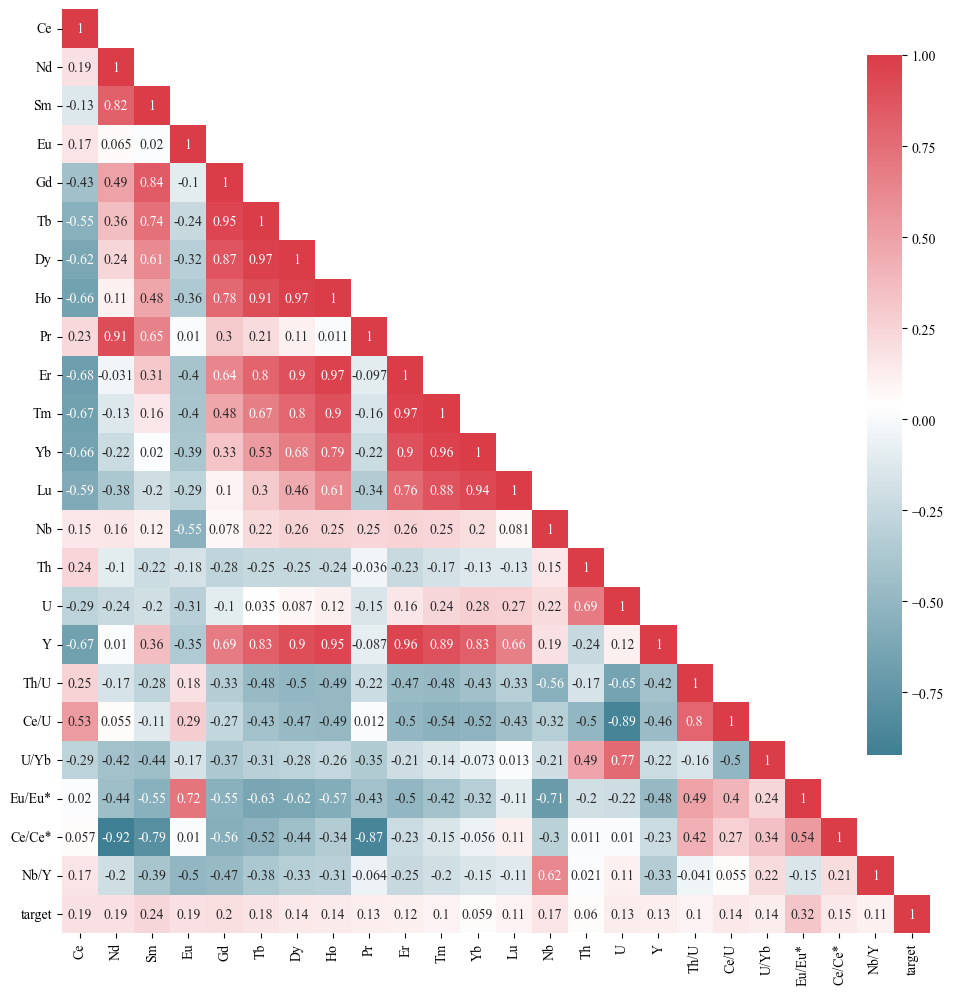

In [63]:
corr_matrix = X_clr_scaler.corr()
mutual_info = mutual_info_classif(X_clr_scaler, z)
mutual_info_series = pd.Series(mutual_info, index = X_clr_scaler.columns)
sorted_mutual_info = mutual_info_series.sort_values(ascending=False)
sorted_mutual_info = round(sorted_mutual_info,3)
print(sorted_mutual_info)
# 输出排序后的特征及其互信息分数
corr_with_target = pd.Series(mutual_info, index=X_clr_scaler.columns, name='target')
complete_corr_matrix = corr_matrix.copy()
complete_corr_matrix[(complete_corr_matrix<0.01) & (complete_corr_matrix>0)] = 0.01
complete_corr_matrix[(complete_corr_matrix>-0.01) & (complete_corr_matrix<0)] = -0.01
complete_corr_matrix['target'] = corr_with_target
complete_corr_matrix.loc['target'] = np.append(corr_with_target, 1)
# 可视化热力图
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(complete_corr_matrix,dtype = bool),k = 1)
colors = ["#3f7f93", "white", "#da3c48"]  # -1 为深蓝色，0 为白色，1 为红色
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

ax = sns.heatmap(complete_corr_matrix, mask = mask, annot=True, cmap=cmap)
cbar = ax.collections[0].colorbar
cbar.ax.set_position([0.7,0.1,0.025,0.9])
# plt.savefig("../Picture/Fig 4/correlation heatmap.pdf",transparent = True, dpi = 600, bbox_inches = "tight")
# plt.savefig("../Picture/Fig 4/correlation heatmap.png",transparent = True, dpi = 600, bbox_inches = "tight")
plt.show()



In [64]:
ranked_feature = sorted_mutual_info.index
selected_features = []
# 使用列表来保持顺序
features_to_keep = list(ranked_feature)
print(features_to_keep)

for selected in ranked_feature:
    keep = True
    features_to_remove = []  # 改用列表存储要移除的特征
    for feature in features_to_keep:
        if feature == selected:
            continue
        if np.abs(corr_matrix.loc[feature, selected]) > 0.7:
            if sorted_mutual_info[feature] > sorted_mutual_info[selected]:
                features_to_remove.append(selected)
                break
            else:
                features_to_remove.append(feature)
    
    # 从features_to_keep中移除要删除的特征
    features_to_keep = [f for f in features_to_keep if f not in features_to_remove]

selected_features = features_to_keep

print("Selected Features based on Mutual Information and Correlation:")
print(selected_features)

['Eu/Eu*', 'Sm', 'Gd', 'Ce', 'Eu', 'Nd', 'Tb', 'Nb', 'Ce/Ce*', 'Ce/U', 'Dy', 'Ho', 'U/Yb', 'U', 'Y', 'Pr', 'Er', 'Nb/Y', 'Lu', 'Tm', 'Th/U', 'Th', 'Yb']
Selected Features based on Mutual Information and Correlation:
['Eu/Eu*', 'Sm', 'Ce', 'Ce/U', 'Dy', 'U/Yb', 'Pr', 'Nb/Y', 'Lu', 'Th']


# model construction

In [66]:
cols =['Genetic type'] + selected_features
data = dataset.loc[:, cols]
data = data.dropna()    #去空值

X = data.drop(['Genetic type'], axis=1).astype(float)
y = data['Genetic type']


clr = Clr()
X = clr.fit_transform(X)


print(X)
print(len(data))
print(y.value_counts())
print(X.describe())

        Eu/Eu*    Sm     Ce      Ce/U     Dy      U/Yb    Pr      Nb/Y     Lu  \
1     0.076614  2.30   53.5  0.019933  172.3  2.620326  0.05  0.017070  198.0   
4     0.369854  2.70   36.5  0.188144   78.8  0.528322  0.05  0.003314   69.2   
6     0.324446  2.80   58.2  0.131973   90.0  1.052506  0.10  0.005699   79.1   
7     0.437402  4.60   82.0  0.155303  147.2  0.747240  0.10  0.004529  132.7   
8     0.478907  8.30  143.1  0.216490  182.4  0.935201  0.30  0.006417  125.8   
...        ...   ...    ...       ...    ...       ...   ...       ...    ...   
2321  0.122231  4.11   20.4  0.217252   65.2  0.424887  0.73  0.003001   38.8   
2322  0.115919  2.30   20.5  0.443723   46.2  0.286957  0.04  0.003347   27.9   
2323  0.083568  1.82   16.9  0.278878   35.4  0.473438  0.04  0.005134   23.5   
2324  0.182635  3.28   14.0  0.472973   52.9  0.188535  0.14  0.002952   27.7   
2325  0.117958  2.49   16.1  0.288014   45.6  0.360645  0.05  0.003831   27.7   

          Th  
1     2094.0

In [67]:
# # 编码
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(y)
y = label_encoder.transform(y)
print(y)
print(Counter(y))
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Label mapping:", label_mapping)

[3 3 3 ... 1 1 1]
Counter({2: 710, 3: 515, 1: 437, 0: 348})
Label mapping: {'A1-type': 0, 'A2-type': 1, 'I-type': 2, 'S-type': 3}


In [68]:
#split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_test_col = X_test.columns
smote = SMOTE(random_state=42)
X_train_, y_train_ = smote.fit_resample(X_train, y_train)
X_train_copy = X_train_.copy(deep=True)
scaler_train = MinMaxScaler() 
X_train_ = scaler_train.fit_transform(X_train_)
X_test_ = scaler_train.transform(X_test)
X_test_ = pd.DataFrame(X_test_, columns=X_test_col)
X_test_

,Eu/Eu*,Sm,Ce,Ce/U,Dy,U/Yb,Pr,Nb/Y,Lu,Th
0,0.685023,0.440406,0.610110,0.938728,0.332629,0.539312,0.469738,0.500443,0.309690,0.275116
1,0.494822,0.547407,0.638336,0.537219,0.392565,0.583003,0.784359,0.413251,0.310236,0.568829
2,0.465170,0.527732,0.540930,0.315436,0.546584,0.607628,0.800331,0.547592,0.511290,0.557416
3,0.659353,0.471099,0.561801,0.503062,0.440750,0.809810,0.458804,0.415817,0.408801,0.489794
4,0.627848,0.670813,0.505793,0.648248,0.481815,0.584916,0.743990,0.257865,0.388064,0.314899
...,...,...,...,...,...,...,...,...,...,...
397,0.563434,0.480551,0.568972,0.457819,0.477613,0.833742,0.473583,0.454318,0.449450,0.533161
398,0.618006,0.601795,0.633768,0.693644,0.469005,0.601320,0.531135,0.249803,0.364946,0.544585
399,0.648013,0.518948,0.624609,0.587930,0.696083,0.563885,0.387652,0.421018,0.605605,0.456486
400,0.694239,0.459610,0.529576,0.674989,0.390203,0.672533,0.475647,0.446354,0.434816,0.400372


# optuna

In [71]:
engine = pyttsx3.init()
 
def optimize_models():  
    def save_study_results(study, model_name):
        """保存每个模型的优化结果和可视化图表"""
        # 保存可视化图表
        plot_optimization_history(study).write_html(f"../Picture/optuna/optimization_history1{model_name}.html")
        plot_param_importances(study).write_html(f"../Picture/optuna/param_importances1{model_name}.html")
        plot_parallel_coordinate(study).write_html(f"../Picture/optuna/parallel_coordinate1{model_name}.html"            )

    # XGBoost 调参
    def objective_xgb_stage(trial):
        param1 = {
            'n_estimators': trial.suggest_int('n_estimators', 20, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.3, step=0.01),
            'max_depth': trial.suggest_int('max_depth', 5, 12),
            'gamma': trial.suggest_float('gamma', 0, 5, step=0.1),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 0.8, step=0.1),
        }
        
        model = xgb.XGBClassifier(**param1)
        pipe = pp([("smote",smote),("scaler",scaler),("model",model)])
        score = cvs(pipe, X_train, y_train, scoring="f1_macro", cv=10, n_jobs=-1).mean()
        score = 1 - score
        return score
    
    print("Optimizing XGBoost...")
    study_xgb_stage = optuna.create_study(direction='minimize')
    study_xgb_stage.optimize(objective_xgb_stage, n_trials=500, n_jobs=-1)
    save_study_results(study_xgb_stage, "XGBoost")
    print('Best trial for XGBoost:', study_xgb_stage.best_trial.params)
    # rf 调参
    print("Optimizing RandomForest...")
    
    def objective_rf_stage(trial):
        param = {
            'n_estimators':trial.suggest_int('n_estimators',20,500), 
            'max_depth': trial.suggest_int('max_depth', 5,20),
            'max_features': trial.suggest_int('max_features',2,7),
            'min_samples_leaf':trial.suggest_int('min_samples_leaf', 2,20),
            'min_samples_split':trial.suggest_int('min_samples_split', 2,20),
            'criterion':trial.suggest_categorical('criterion',['gini','entropy'])
                        }
        model = RandomForestClassifier(**param)
        pipe = pp([("smote",smote),("scaler",scaler),("model",model)])
        score = cvs(pipe, X_train, y_train, scoring = "f1_macro",cv = 10,n_jobs = 5).mean()
        score = 1 - score
        return score
    
    study_rf_stage = optuna.create_study(direction='minimize')
    study_rf_stage.optimize(objective_rf_stage, n_trials=500, n_jobs=-1)
    save_study_results(study_rf_stage, "RandomForest")
    print('Best trial for Rf Stage:', study_rf_stage.best_trial.params)

    def objective_knn(trial):
        param = {
            'n_neighbors': trial.suggest_int("n_neighbors",3,15),
            'p': trial.suggest_int("p",1,2), 
            "weights": trial.suggest_categorical('weights',['uniform','distance'])
                }
        model = KNeighborsClassifier(**param)
        pipe = pp([("smote",smote),("scaler",scaler),("model",model)])
        score = cvs(pipe, X_train, y_train, scoring = "f1_macro",cv = 10,n_jobs = -1).mean()
        score = 1 - score
        return score
    # KNN 调参
    print("Optimizing KNN...")
    study_knn = optuna.create_study(direction='minimize')
    study_knn.optimize(objective_knn, n_trials=200, n_jobs=5)
    print('Best trial for KNN:', study_knn.best_trial.params,'score', 1-study_knn.best_value)
    save_study_results(study_knn, "KNN")

    def objective_svm(trial):
        SVC_C=trial.suggest_float('SVC_C',1e-2,1e2) 
        SVC_gamma=trial.suggest_float('SVC_gamma',1e-2,1e1)
        SVC_kernel = trial.suggest_categorical('weights',['rbf','linear'])   
        model = svm.SVC(kernel = SVC_kernel, C=SVC_C, gamma=SVC_gamma)
        pipe = pp([("smote",smote),("scaler",scaler),("model",model)])
        score = cvs(pipe, X_train, y_train, scoring = "f1_macro",cv = 10, n_jobs = -1).mean()
        score = 1 - score
        return score
    # svm 调参
    print("Optimizing SVM...")
    
    study_svm = optuna.create_study(direction='minimize')
    study_svm.optimize(objective_svm, n_trials=500, n_jobs=10)
    print('Best trial for SVM:', study_svm.best_trial.params,'score', 1-study_svm.best_value)
    save_study_results(study_svm, "SVM")
    engine.say("Optimization for all models is complete.")
    engine.runAndWait()

# 运行整个模型优化流程


In [44]:
optimize_models()

[I 2025-04-21 22:48:12,701] A new study created in memory with name: no-name-ad251748-a569-43c1-9689-912dbeca724e


Optimizing SVM...


[I 2025-04-21 22:48:13,350] Trial 4 finished with value: 0.1275334132153778 and parameters: {'SVC_C': 9.681506520143598, 'SVC_gamma': 2.5276476046296232, 'weights': 'rbf'}. Best is trial 4 with value: 0.1275334132153778.
[I 2025-04-21 22:48:13,986] Trial 3 finished with value: 0.33782422394945255 and parameters: {'SVC_C': 43.073138351602395, 'SVC_gamma': 5.651680095131241, 'weights': 'linear'}. Best is trial 4 with value: 0.1275334132153778.
[I 2025-04-21 22:48:14,010] Trial 0 finished with value: 0.110660745015427 and parameters: {'SVC_C': 47.27359940141211, 'SVC_gamma': 2.8644717199023844, 'weights': 'rbf'}. Best is trial 0 with value: 0.110660745015427.
[I 2025-04-21 22:48:14,123] Trial 2 finished with value: 0.3412029194827323 and parameters: {'SVC_C': 5.509531638423758, 'SVC_gamma': 9.678525668303983, 'weights': 'linear'}. Best is trial 0 with value: 0.110660745015427.
[I 2025-04-21 22:48:14,218] Trial 1 finished with value: 0.3363612198229672 and parameters: {'SVC_C': 14.55255709

Best trial for SVM: {'SVC_C': 5.073978674819591, 'SVC_gamma': 8.122934129468526, 'weights': 'rbf'} score 0.9042767220551824


# Model

In [73]:

models = {
    'SVM': svm.SVC(kernel="rbf", C = 5.074, gamma = 8.123, probability=True),   
    'RF': RandomForestClassifier(n_estimators = 458, max_depth = 18, max_features = 3, min_samples_leaf = 2, min_samples_split = 2, criterion = "entropy"),#0.881
    'XGboost': XGBClassifier(n_estimators = 177, learning_rate = 0.26, max_depth = 11, gamma = 0, colsample_bytree = 0.7), #0.881
    'KNN': KNeighborsClassifier(n_neighbors = 8, weights='distance', p = 2)    
}
Mods = (
    'SVM',
    "RF",
    "XGboost",
    "KNN"
)

In [74]:
for clf, model in models.items():
    all_accuracy = []
    all_f1 = []
    all_precision = []
    all_recall = []
    all_auc = []
    print(clf)
    for train_idx, test_inx in KFold(n_splits=10, shuffle=True, random_state=42).split(X_train, y_train):
        X_train_fold = X_train.iloc[train_idx]
        y_train_fold = y_train[train_idx]
        X_test_fold = X_train.iloc[test_inx]
        y_test_fold = y_train[test_inx]
        
        pipe = pp([("smote",smote),("scaler",scaler),("model",model)])
        pipe.fit(X_train_fold, y_train_fold)
        
        # Get predictions and probabilities
        y_pred = pipe.predict(X_test_fold)
        y_prob = pipe.predict_proba(X_test_fold)
        
        # Calculate metrics
        all_accuracy.append(accuracy_score(y_test_fold, y_pred))
        all_f1.append(f1_score(y_test_fold, y_pred, average='macro'))
        all_precision.append(precision_score(y_test_fold, y_pred, average='macro'))
        all_recall.append(recall_score(y_test_fold, y_pred, average='macro'))
        
        # Calculate ROC AUC using one-vs-rest approach
        y_test_bin = label_binarize(y_test_fold, classes=np.unique(y_train))
        all_auc.append(roc_auc_score(y_test_bin, y_prob, multi_class='ovr'))
        
    print("Accuracy:", round(np.mean(all_accuracy),3), "±", round(np.std(all_accuracy),3))
    print("F1:", round(np.mean(all_f1),3), "±", round(np.std(all_f1),3))
    print("Precision:", round(np.mean(all_precision),3), "±", round(np.std(all_precision),3))
    print("Recall:", round(np.mean(all_recall),3), "±", round(np.std(all_recall),3))
    print("AUC:", round(np.mean(all_auc),3), "±", round(np.std(all_auc),3))

SVM
Accuracy: 0.907 ± 0.012
F1: 0.897 ± 0.011
Precision: 0.899 ± 0.009
Recall: 0.898 ± 0.014
AUC: 0.98 ± 0.006
RF
Accuracy: 0.875 ± 0.021
F1: 0.859 ± 0.022
Precision: 0.867 ± 0.021
Recall: 0.858 ± 0.021
AUC: 0.973 ± 0.006
XGboost
Accuracy: 0.88 ± 0.017
F1: 0.865 ± 0.018
Precision: 0.868 ± 0.019
Recall: 0.866 ± 0.018
AUC: 0.973 ± 0.007
KNN
Accuracy: 0.884 ± 0.023
F1: 0.871 ± 0.025
Precision: 0.876 ± 0.024
Recall: 0.87 ± 0.025
AUC: 0.97 ± 0.006


# 混淆矩阵

d:\Program\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


SVM
              precision  recall  f1-score  support
0                 0.884   0.871     0.878   70.000
1                 0.928   0.885     0.906   87.000
2                 0.906   0.951     0.928  142.000
3                 0.911   0.893     0.902  103.000
accuracy          0.908   0.908     0.908    0.908
macro avg         0.907   0.900     0.903  402.000
weighted avg      0.908   0.908     0.908  402.000


d:\Program\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RF
              precision  recall  f1-score  support
0                 0.908   0.843     0.874   70.000
1                 0.878   0.908     0.893   87.000
2                 0.904   0.930     0.917  142.000
3                 0.891   0.874     0.882  103.000
accuracy          0.896   0.896     0.896    0.896
macro avg         0.895   0.889     0.891  402.000
weighted avg      0.896   0.896     0.895  402.000
XGboost
              precision  recall  f1-score  support
0                 0.884   0.871     0.878   70.000
1                 0.876   0.897     0.886   87.000
2                 0.911   0.937     0.924  142.000
3                 0.898   0.854     0.876  103.000
accuracy          0.896   0.896     0.896    0.896
macro avg         0.892   0.890     0.891  402.000
weighted avg      0.895   0.896     0.895  402.000
KNN
              precision  recall  f1-score  support
0                 0.899   0.886     0.892     70.0
1                 0.940   0.897     0.918     87.0
2               

d:\Program\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


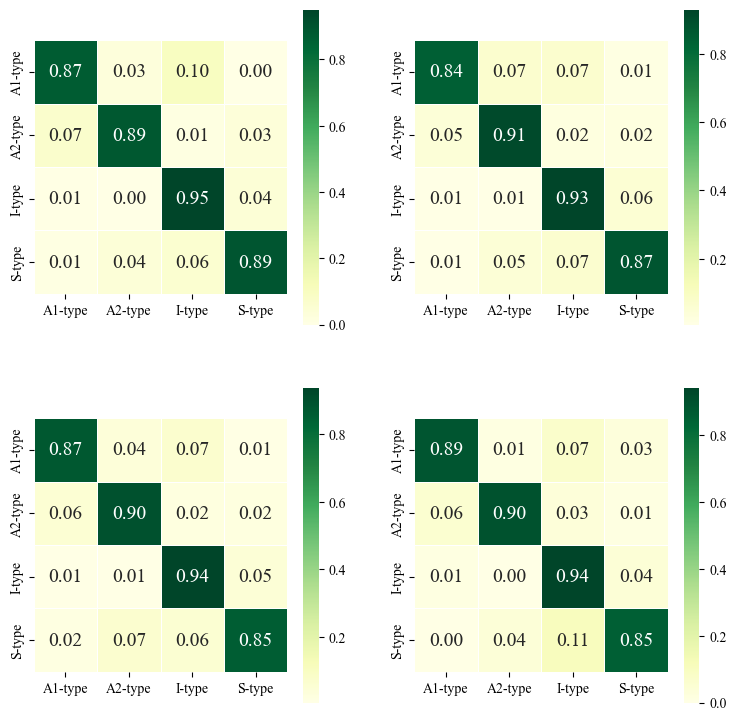

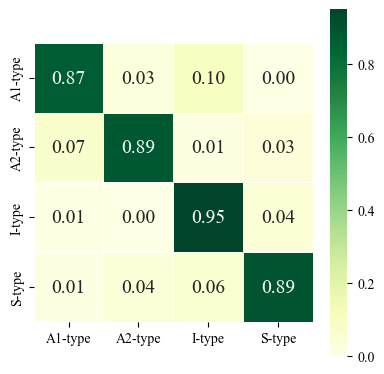

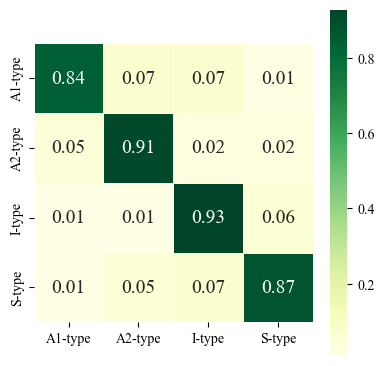

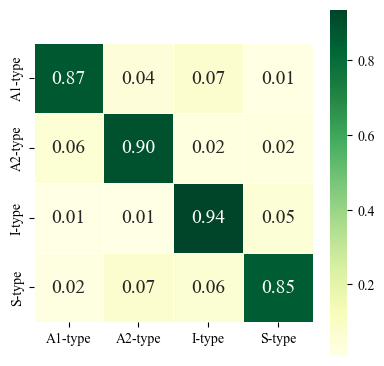

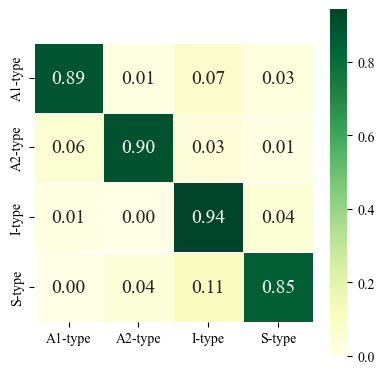

In [ ]:
fig, axes = plt.subplots(2,2,figsize=(9,9))
for i, (clf, clfn, ax) in enumerate(zip(models, Mods, axes.flatten())):
    # 创建单独的图形对象
    fig_single = plt.figure(figsize=(4.5,4.5))
    ax_single = fig_single.add_subplot(111)
    
    # 模型训练和预测
    models[clfn].fit(X_train_, y_train_)
    y_test_pred = models[clfn].predict(X_test_)
    cm = pd.DataFrame(confusion_matrix(y_test, y_test_pred, normalize='true'), 
                     columns=index, index=index)
    
    # 在原始子图中绘制
    sns.heatmap(cm, annot=True, fmt=".2f", linewidths=0.5, ax=ax, 
                cmap="YlGn", square=True, annot_kws={"size":14})
    # ax.set_xticks([])
    # ax.set_yticks([])
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])
    
    # 在单独的图中绘制
    # sns.heatmap(cm, annot=True, fmt=".2f", linewidths=0.5, ax=ax_single, 
    #             cmap="YlGn", square=True, annot_kws={"size":14})

    # ax_single.set_xticklabels([])
    # ax_single.set_yticklabels([])

    
    # 打印报告
    print(clfn)
    report = classification_report(y_test, y_test_pred, output_dict=True)
    df = pd.DataFrame(report).transpose()
    print(df.round(3))

## ROC carve

#4a9ad6


d:\Program\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


[0.         0.         0.         0.00301205 0.00301205 0.0060241
 0.0060241  0.00903614 0.00903614 0.01204819 0.01204819 0.01807229
 0.01807229 0.02108434 0.02108434 0.02409639 0.02409639 0.02710843
 0.02710843 0.03313253 0.03313253 0.04216867 0.04216867 0.04819277
 0.04819277 0.07228916 0.07228916 0.0813253  0.0813253  0.71987952
 0.71987952 1.        ]
[0.         0.01428571 0.24285714 0.24285714 0.42857143 0.42857143
 0.74285714 0.74285714 0.81428571 0.81428571 0.82857143 0.82857143
 0.87142857 0.87142857 0.88571429 0.88571429 0.9        0.9
 0.91428571 0.91428571 0.92857143 0.92857143 0.94285714 0.94285714
 0.95714286 0.95714286 0.97142857 0.97142857 0.98571429 0.98571429
 1.         1.        ]
[0.         0.         0.         0.0031746  0.0031746  0.00634921
 0.00634921 0.00952381 0.00952381 0.01587302 0.01587302 0.02222222
 0.02222222 0.02857143 0.02857143 0.03492063 0.03492063 0.05714286
 0.05714286 0.08888889 0.08888889 0.15555556 0.15555556 0.24126984
 0.24126984 0.38095238

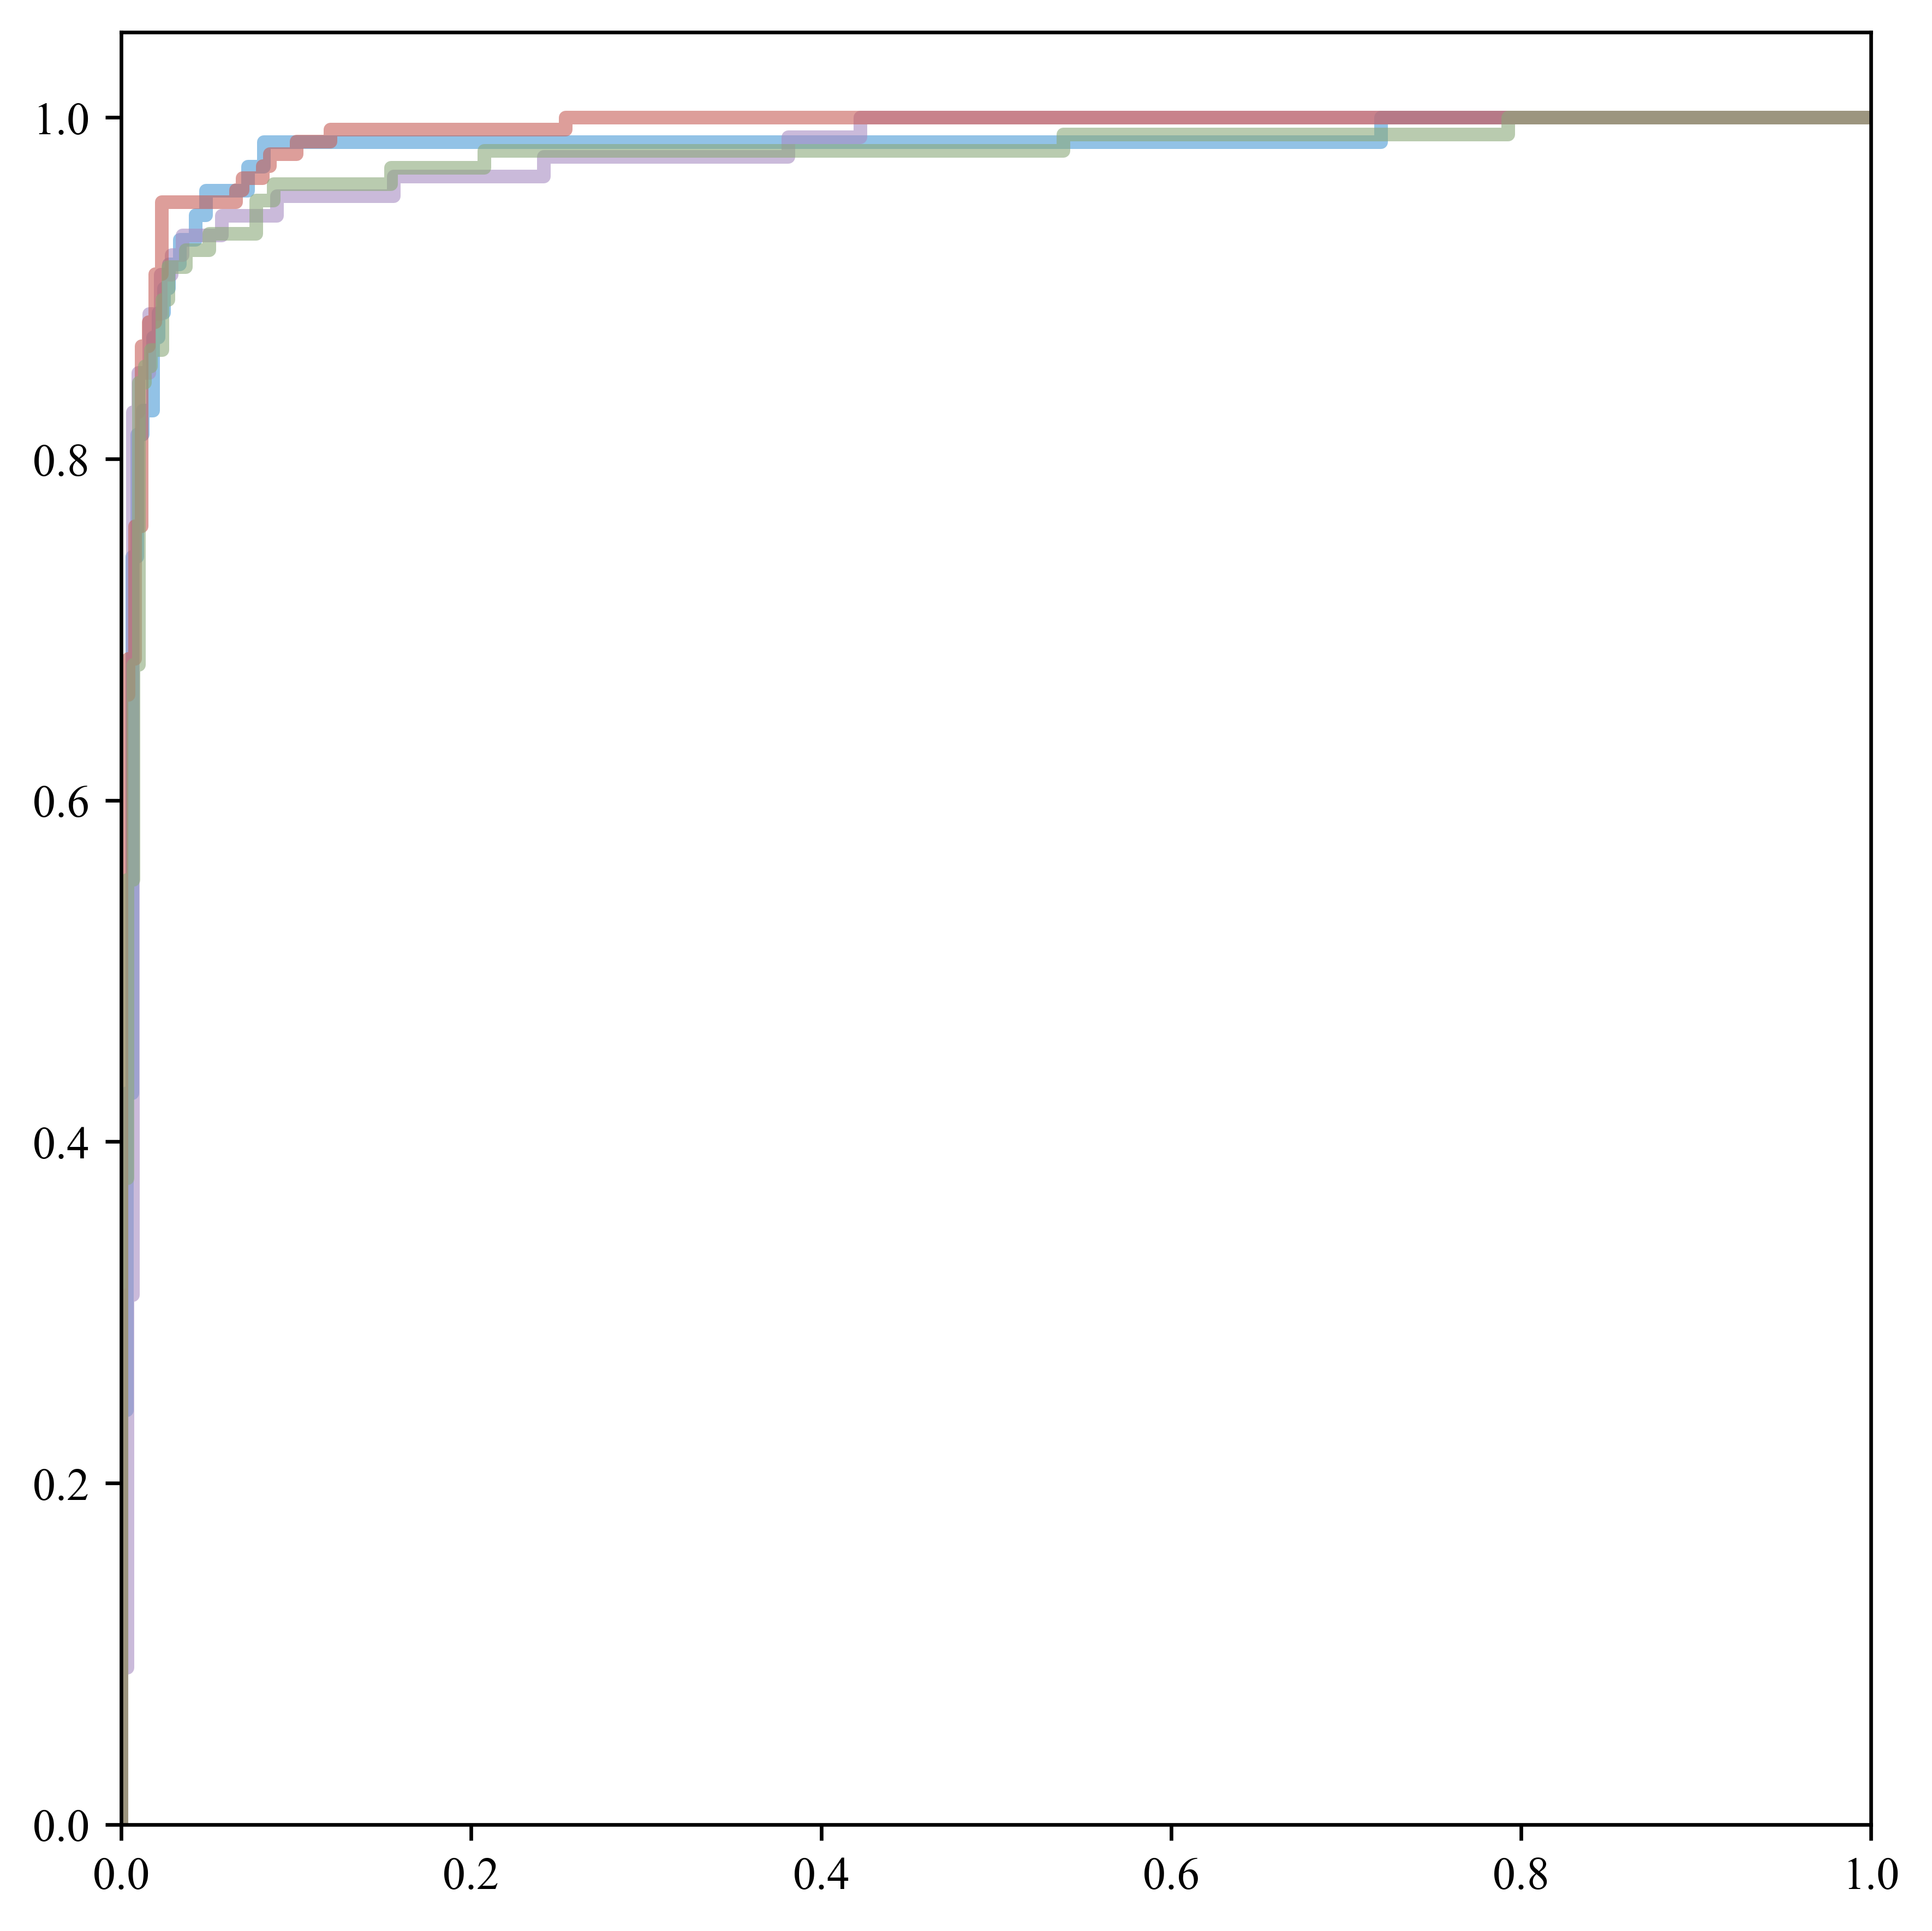

d:\Program\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


[0.         0.         0.         0.00301205 0.00301205 0.00903614
 0.00903614 0.01204819 0.01204819 0.01506024 0.01506024 0.01807229
 0.01807229 0.03012048 0.03012048 0.06626506 0.06626506 0.07228916
 0.07228916 0.13253012 0.13253012 0.18373494 0.18373494 0.20481928
 0.20481928 0.20783133 0.20783133 0.2560241  0.2560241  0.65060241
 0.65060241 0.74096386 0.74698795 0.75301205 0.75903614 0.77108434
 0.77710843 0.78915663 0.79518072 0.81325301 0.81927711 0.8253012
 0.8373494  0.84939759 0.85843373 0.86445783 0.87048193 0.87349398
 0.87951807 0.89156627 0.89457831 0.90060241 0.91566265 0.92771084
 0.93072289 0.93674699 0.93975904 1.        ]
[0.         0.01428571 0.4        0.4        0.68571429 0.68571429
 0.71428571 0.71428571 0.75714286 0.75714286 0.78571429 0.78571429
 0.84285714 0.84285714 0.87142857 0.87142857 0.88571429 0.88571429
 0.91428571 0.91428571 0.92857143 0.92857143 0.94285714 0.94285714
 0.95714286 0.95714286 0.97142857 0.97142857 0.98571429 0.98571429
 1.         1.   

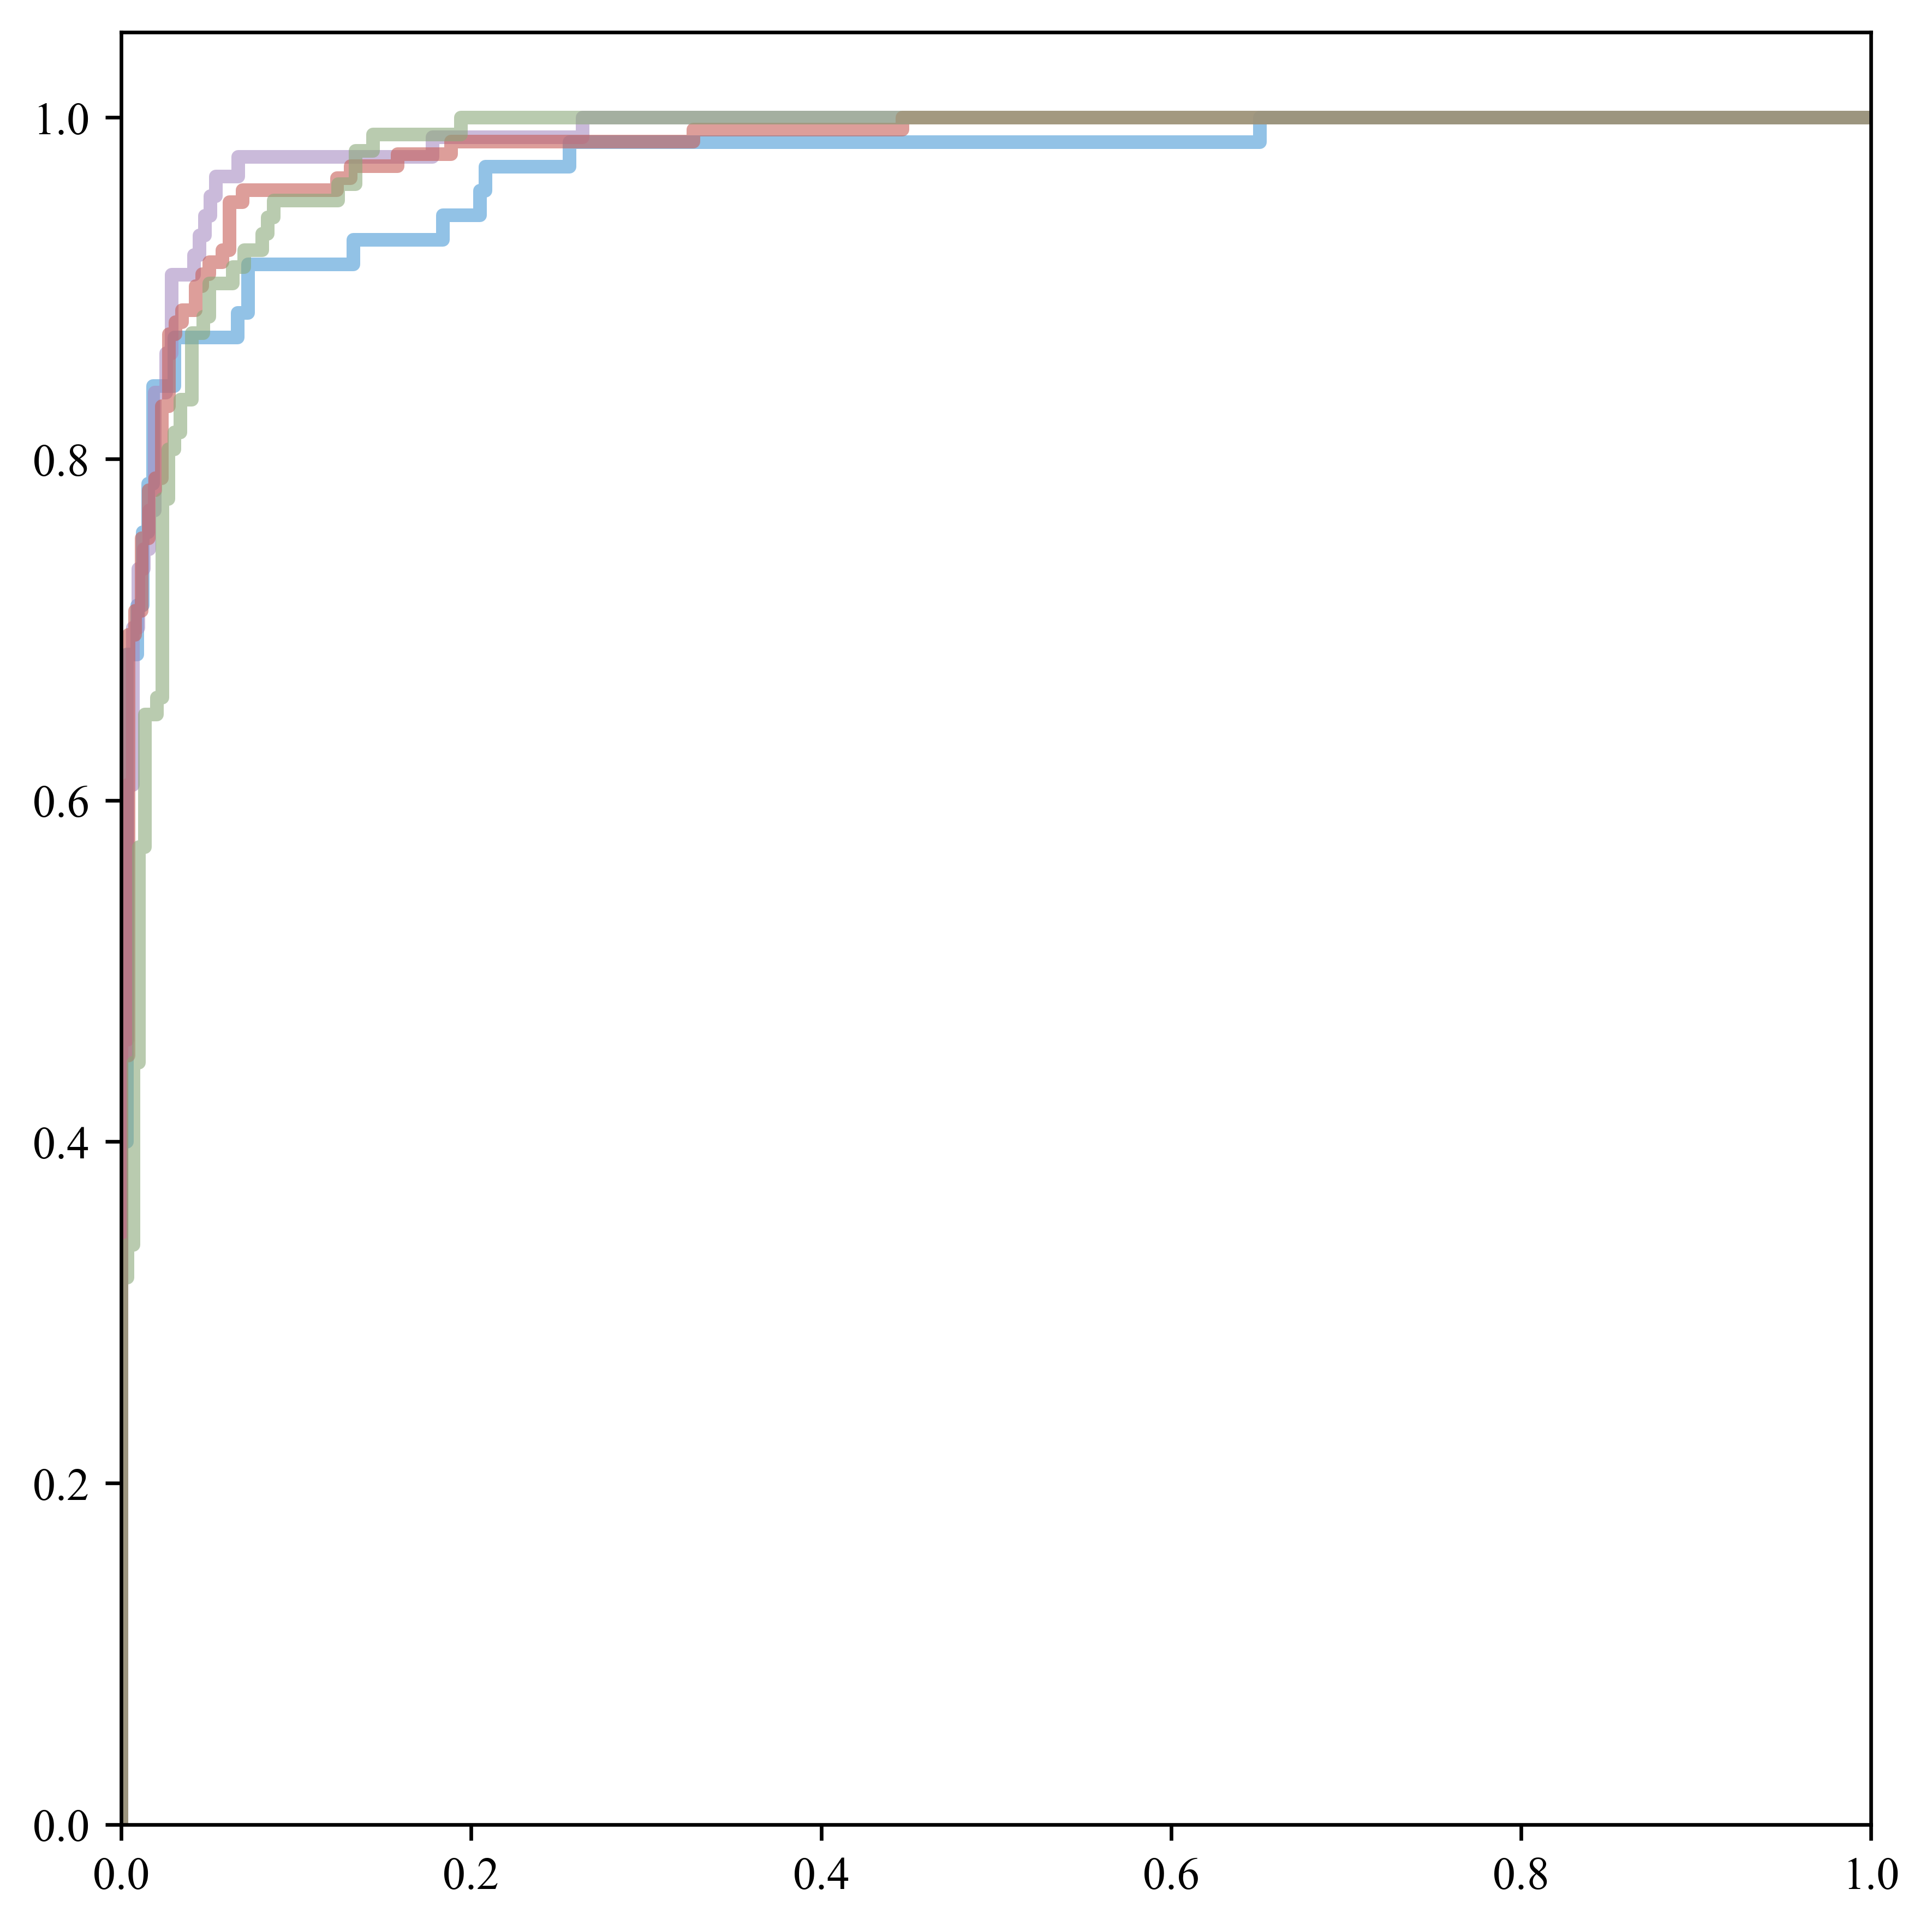

[0.         0.         0.         0.00301205 0.00301205 0.01204819
 0.01204819 0.02108434 0.02108434 0.03012048 0.03012048 0.04819277
 0.04819277 0.06024096 0.06024096 0.06927711 0.06927711 0.14156627
 0.14156627 0.27108434 0.27108434 0.30120482 0.30120482 0.3253012
 0.3253012  0.87048193 0.87048193 1.        ]
[0.         0.01428571 0.6        0.6        0.81428571 0.81428571
 0.82857143 0.82857143 0.87142857 0.87142857 0.88571429 0.88571429
 0.9        0.9        0.91428571 0.91428571 0.92857143 0.92857143
 0.94285714 0.94285714 0.95714286 0.95714286 0.97142857 0.97142857
 0.98571429 0.98571429 1.         1.        ]
[0.         0.         0.         0.0031746  0.0031746  0.00634921
 0.00634921 0.01269841 0.01269841 0.01587302 0.01587302 0.01904762
 0.01904762 0.02222222 0.02222222 0.02539683 0.02539683 0.02857143
 0.02857143 0.03174603 0.03174603 0.04126984 0.04126984 0.05079365
 0.05079365 0.05714286 0.05714286 0.06031746 0.06031746 0.10793651
 0.10793651 0.17142857 0.17142857 1.  

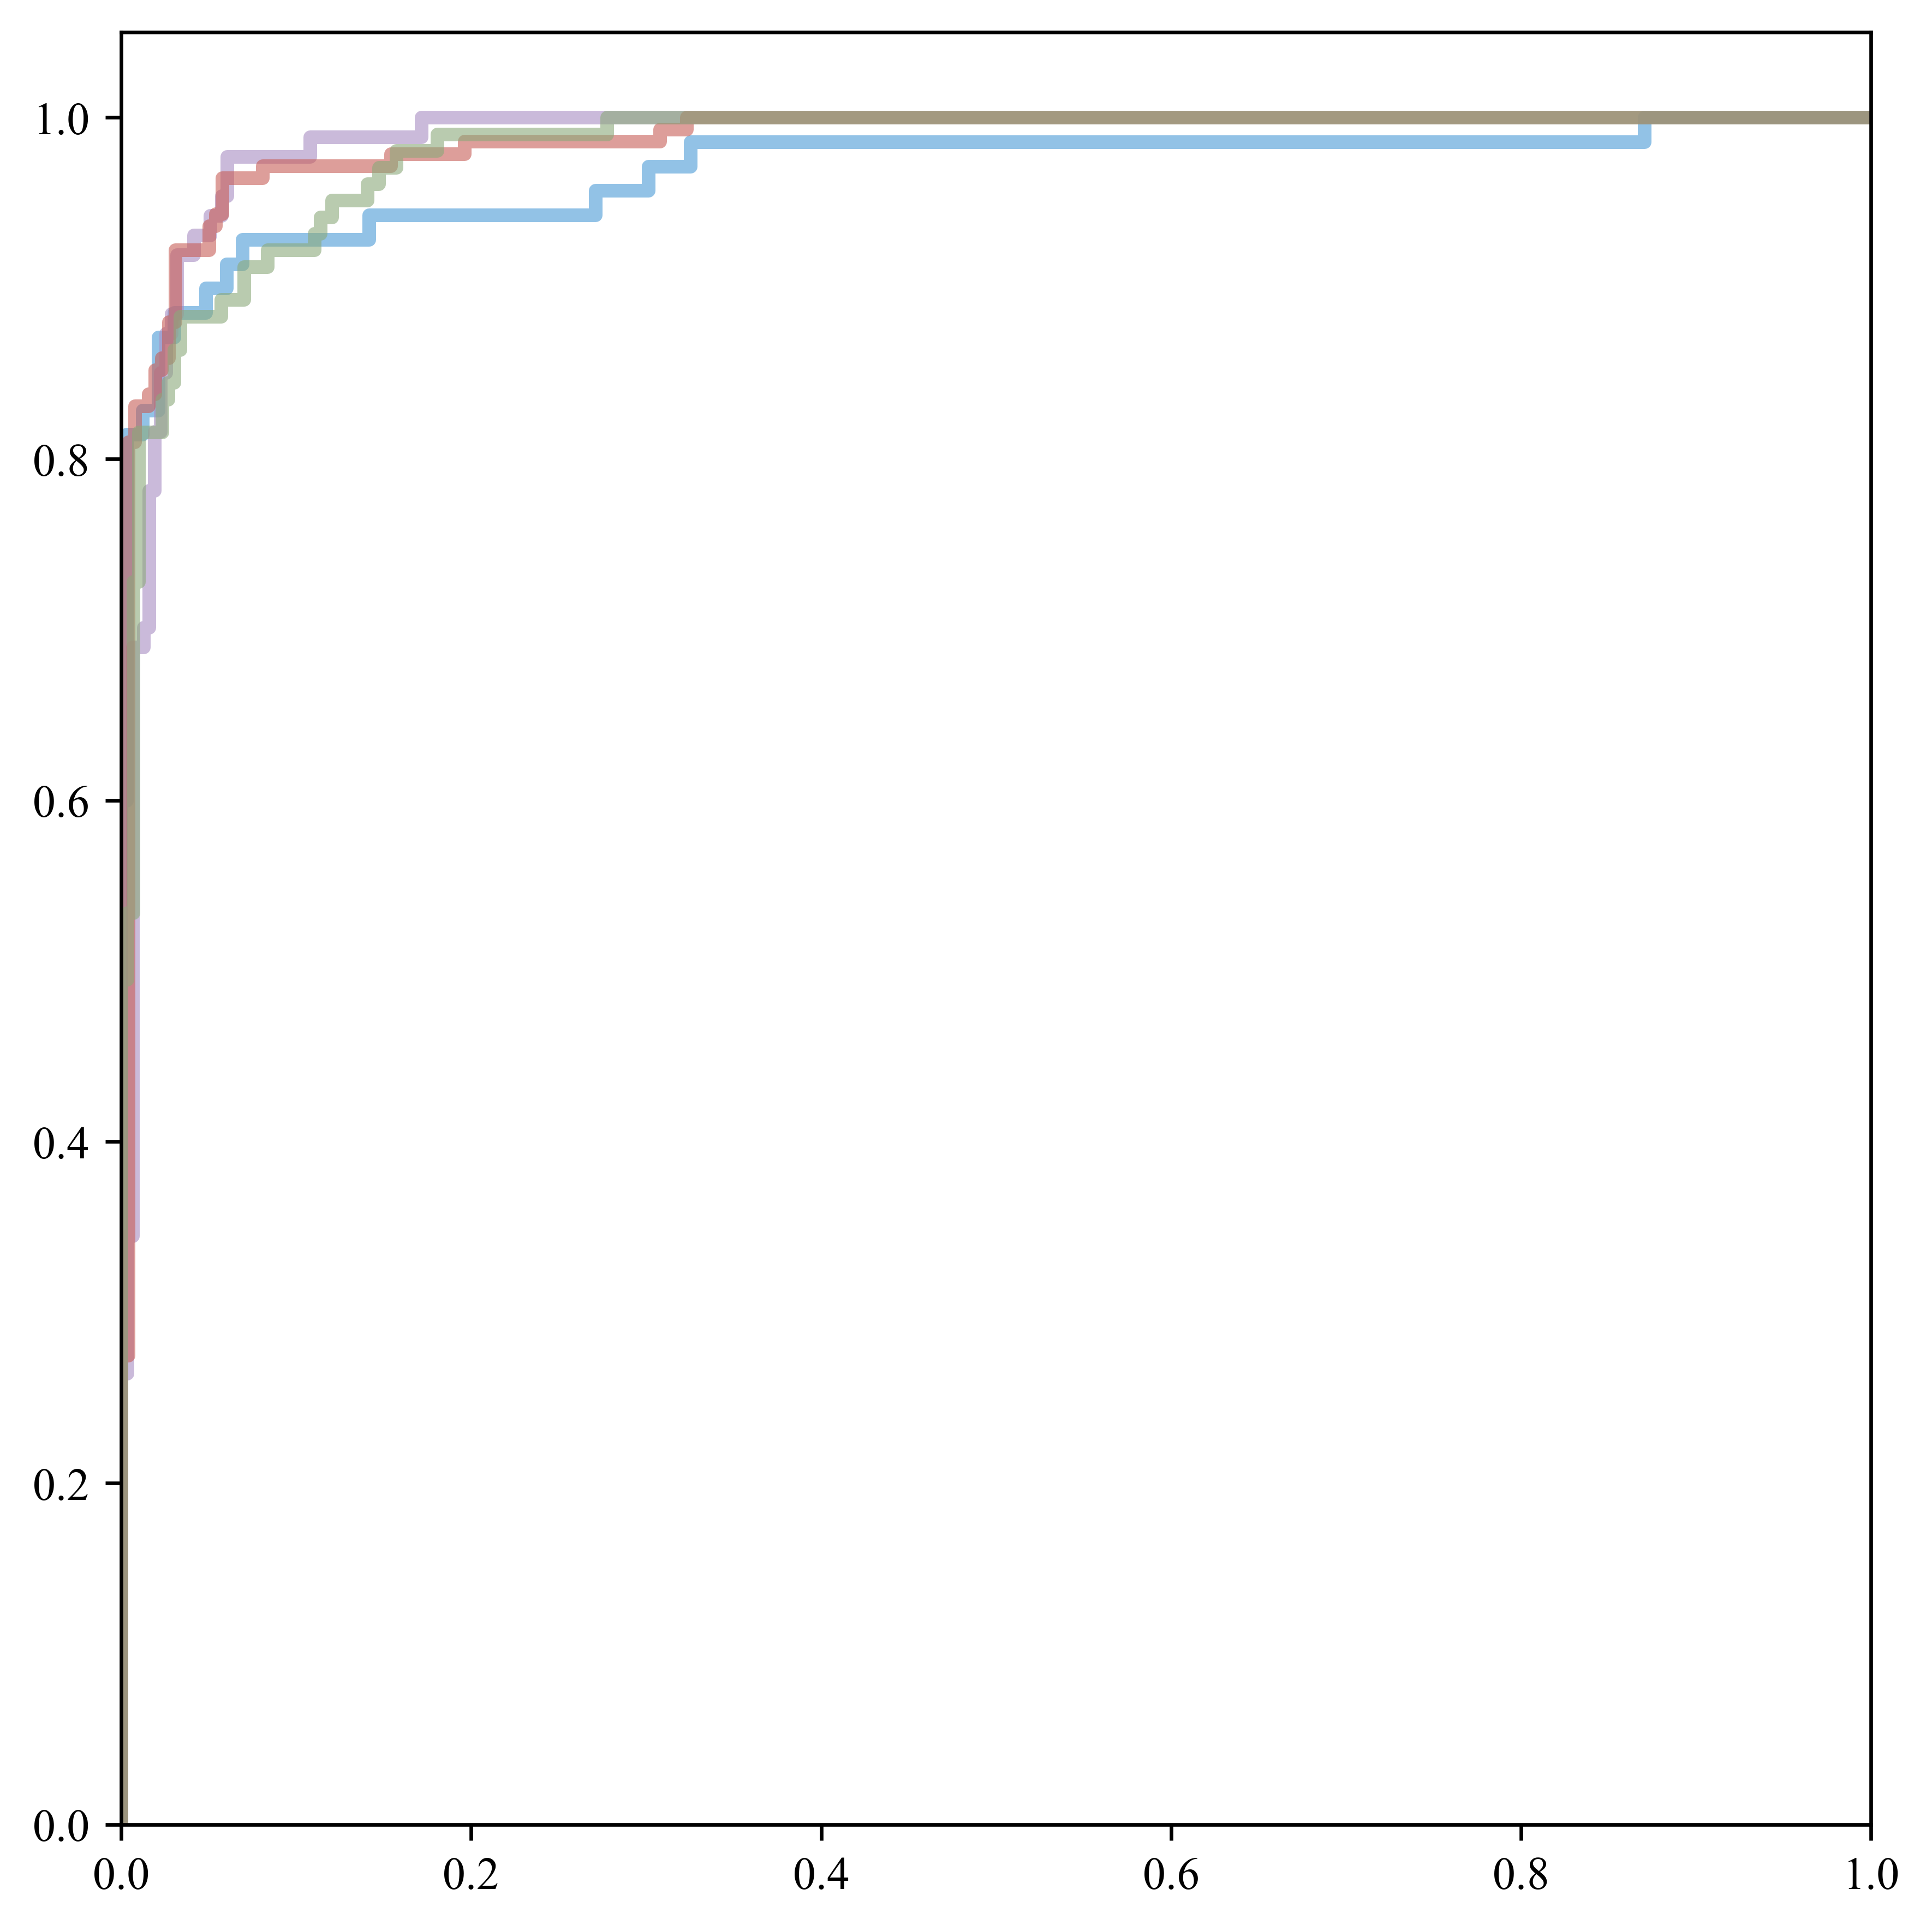

d:\Program\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


[0.         0.0060241  0.0060241  0.00903614 0.00903614 0.01204819
 0.01204819 0.01506024 0.01506024 0.01807229 0.01807229 0.05722892
 0.05722892 0.06927711 0.06927711 0.0873494  0.0873494  0.09638554
 0.09638554 0.11445783 0.11445783 0.17771084 1.        ]
[0.         0.67142857 0.78571429 0.78571429 0.82857143 0.82857143
 0.84285714 0.84285714 0.85714286 0.85714286 0.88571429 0.88571429
 0.9        0.9        0.91428571 0.91428571 0.92857143 0.92857143
 0.94285714 0.94285714 0.95714286 0.95714286 1.        ]
[0.         0.0031746  0.0031746  0.00952381 0.00952381 0.01269841
 0.01269841 0.01904762 0.01904762 0.02222222 0.02222222 0.02857143
 0.02857143 0.03174603 0.03174603 0.07619048 0.07619048 0.0952381
 0.0952381  0.12698413 1.        ]
[0.         0.51724138 0.72413793 0.72413793 0.8045977  0.8045977
 0.89655172 0.89655172 0.90804598 0.90804598 0.91954023 0.91954023
 0.93103448 0.93103448 0.94252874 0.94252874 0.95402299 0.95402299
 0.96551724 0.96551724 1.        ]
[0.         0.

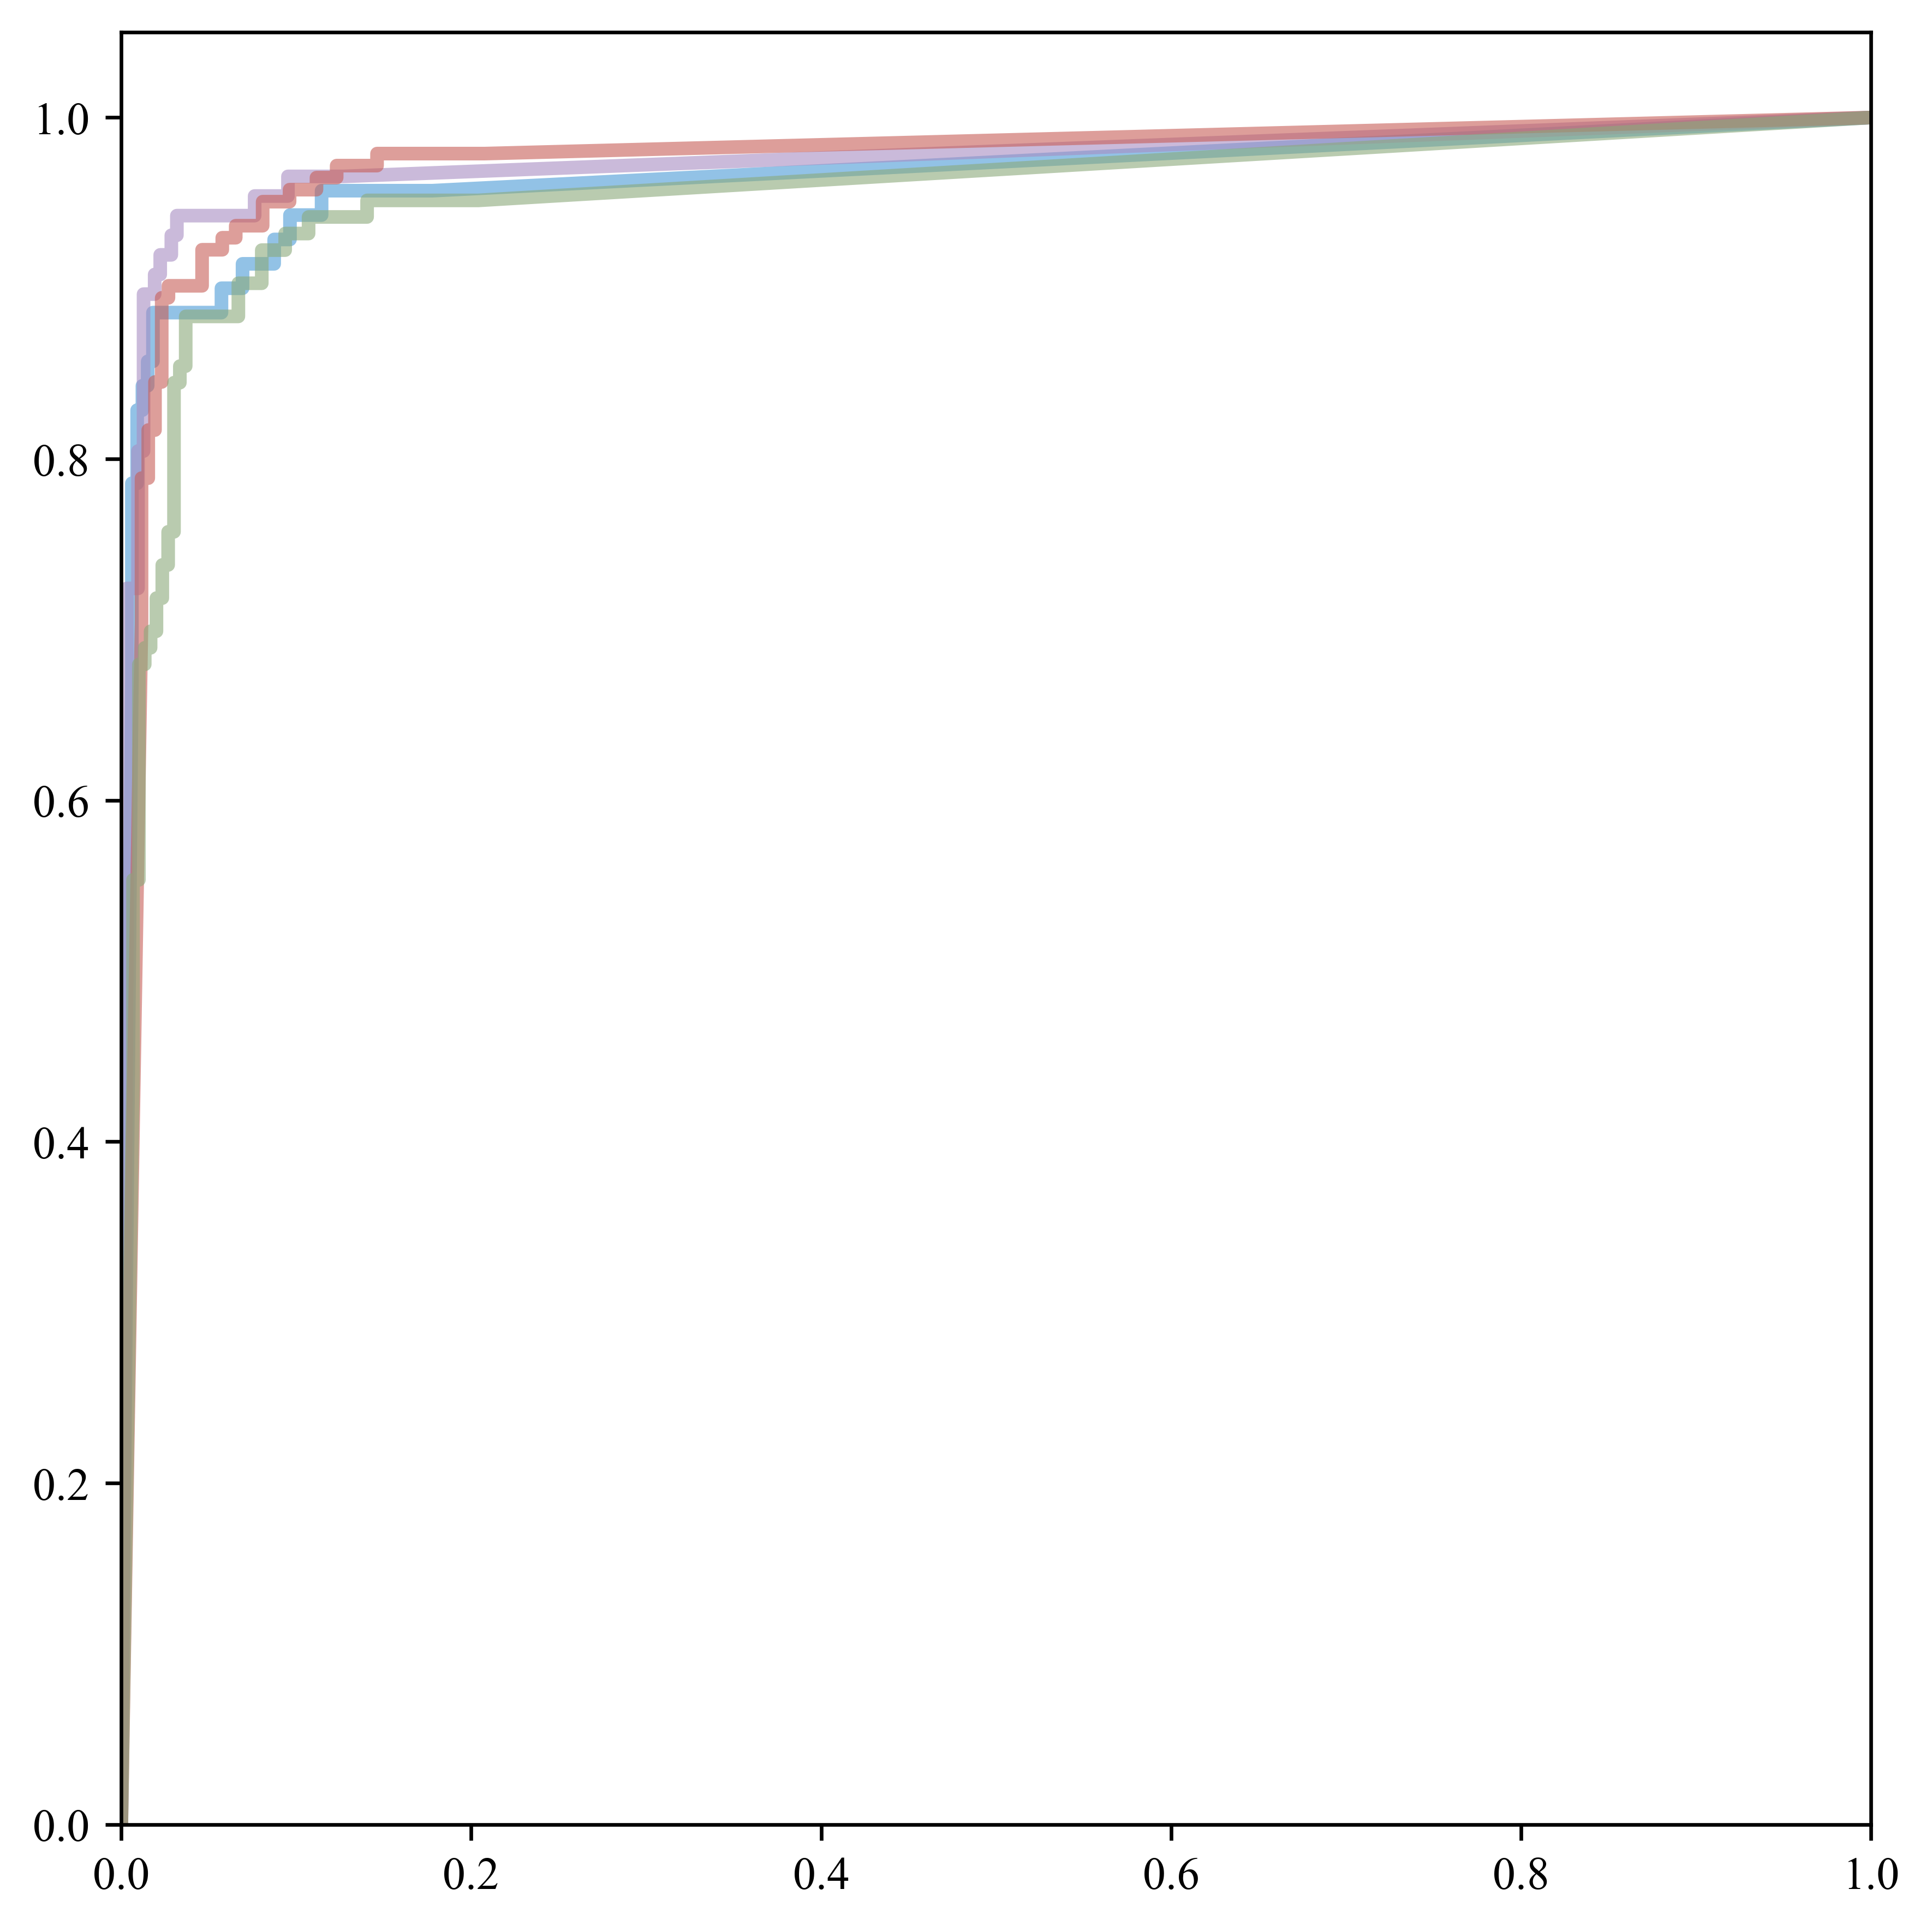

In [76]:
from sklearn.metrics import auc, roc_auc_score
labels = ["A1 type","A2 type","I type","S type"]
# palette = {"A1 type": "#a1d9f6", "A2 type": "#d2cde7",  "I type": "#ed8580","S type": "#d3ead7"}
palette = {
    "A1 type": "#4a9ad6",   # 深蓝
    "A2 type": "#a88dc2",   # 深紫
    "I type": "#c75e57",    # 深橙红
    "S type": "#8ba97a"     # 深绿
}
print(palette[labels[0]])
for model_name in Mods:
    # 训练模型
    models[model_name].fit(X_train_, y_train_)
    # 预测概率
    y_score = models[model_name].predict_proba(X_test_)
    y_test_binarized = label_binarize(y_test,classes = [0,1,2,3])
    # 计算每个类的ROC曲线
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    plt.figure(dpi=600,figsize=(6, 6))
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        print(fpr[i])
        print(tpr[i])

        plt.plot(fpr[i], tpr[i], label=f'{labels[i]} (AUC = {roc_auc[i]:.3f})', 
                color=palette[labels[i]], linewidth=3, alpha=0.6)
    
    # 图像配置
    # plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks = ([])
    plt.yticks = ([]) 
    # plt.legend(loc='lower right')
    # plt.grid()
    plt.tight_layout()
    # plt.savefig(f"../Picture/ROC curve/{model_name}",dpi = 600)
    plt.show()

# SHAP

In [ ]:
import shap

shap.initjs()

In [ ]:
print(y_train)
svm = models["SVM"]
svm.fit(X_train_, y_train_)

# Create background dataset for KernelExplainer
background = shap.kmeans(X_train_, 100)  # Using 100 background samples

# Create KernelExplainer for SVM
explainer = shap.KernelExplainer(svm.predict_proba, background)

# Calculate SHAP values
feature = X_test_.columns.tolist()
shap_values = explainer.shap_values(X_test_)

# Plot SHAP values for each class
for class_idx in range(len(shap_values)):
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values[class_idx],
        X_test_,
        feature_names=feature,
        show=False,
        plot_size=(9, 6),
        title=f'Class {class_idx} SHAP Values'
    )
    
    # Save configuration optimization

    plt.show()
print(shap_values_xgb.shape)
print(shap_values_xgb[:,:,0].shape)
# 批量生成并保存SHAP图
for class_idx in range(4):
    plt.figure(figsize=(10, 6)) 
    print(class_idx)
    shap.summary_plot(
        shap_values_xgb[:,:,class_idx],  # 选择特定类别的SHAP值
        X_test_,
        feature_names=feature,
        show=False,
        plot_size=(9, 6),
        title=f'Class {class_idx} SHAP Values'  # 直接添加标题
    )
    
    # 保存配置优化
    plt.savefig(
        f"xgb_class{class_idx}.png",
        dpi=600,
        transparent=True,
        bbox_inches='tight'  # 防止标签截断
    )
    plt.close()  # 显式释放内存

[2 2 1 ... 2 2 3]


# SDBM

In [ ]:
import ssnp
plt.figure(figsize=(9, 6.5))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
sampler = SMOTE(random_state=42)
X_over, y_over = sampler.fit_resample(X_train, y_train)
print(X_over.isnull().sum())
scaler = MinMaxScaler()
X_over_scaled = scaler.fit_transform(X_over)
X_test_scaled = scaler.transform(X_test)
clf = svm.SVC(kernel="rbf", C = 5.074, gamma = 8.123, probability=True)
ssnp = SSNP(epochs=500, patience=10)

ssnp.fit(X_over_scaled, y_over)

X_ssnp = ssnp.transform(X_over_scaled)
scaler2d = MinMaxScaler()
scaler2d.fit(X_ssnp)

clf.fit(X_over_scaled, y_over)
print(clf.score(X_over_scaled, y_over))

builder = DBMbuilder(clf, ssnp, scaler2d=scaler2d, scalernd=scaler)

ax = builder.plot_prob_map(cmap=custom_cmap)
kwargs  =   {'edgecolor':"k"}
ax = sns.scatterplot(x = scaler2d.transform(X_ssnp)[:, 0], y =scaler2d.transform(X_ssnp)[:, 1], hue=label_encoder.inverse_transform(y_over), hue_order=["A1","A2","I","S"],palette=set2_palette, 
                    alpha=1, s=50, **kwargs)
# ax.legend(labels=[r'$\text{A}_1$',r'$\text{A}_2$',"I","S"],ncol=1, fontsize=10)
ax.legend().remove()

plt.show()

features = ['Eu/Eu*', 'Sm', 'Ce', 'Ce/U', 'Dy', 'U/Yb', 'Pr', 'Nb/Y', 'Lu', 'Th']

explain = Explain(X_over_scaled, X_ssnp, columns=features, epsilon=0.2)
scores = explain.get_confidence_scores()
s = scores['confidence_normalized'].values * 100
kwargs = {'edgecolor': 'k'}
plt.figure(figsize=(9, 6.5))
kwargs = {'edgecolor': 'k'}
ax = builder.plot_prob_map(cmap=custom_cmap)
ax = sns.scatterplot(
    x=scaler2d.transform(X_ssnp)[:, 0], 
    y=scaler2d.transform(X_ssnp)[:, 1], 
    hue=scores['color_plot'].values,
    size=s,  # Use the confidence scores for point sizes
    sizes=(50, 200),  # Define the range of point sizes
    **kwargs)
plt.title('Feature Distribution')
handles, labels = ax.get_legend_handles_labels()
print(labels)
print(handles)
plt.legend(
    labels = labels[:6]
    , handles = handles[:6]
    , title='color_plot'
    , bbox_to_anchor=(0.85, 1)
    , loc='upper left'
)
plt.show()